# Numerical simulation of SDEs

This is a reproduction of the scripts found in Higham, *An algorithmic Introduction to Numerical Simulation of Stochastic Differential Equations*. This paper is an accessible introduction to SDEs, centered around ten MATLAB scripts, which I've converted to Python here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML
css_style = open('../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## Definition of a Wiener Process

<div class="definition">
    
**Definition (Wiener process)** A *standard Wiener process* over [0, T] is a random variable $W(t)$ that depends continuously on $t \in [0, T]$ and satisfies:

1. W(0) = 0, with probability 1.
2. For $0 \leq t_1 < t_2 \leq T$ the random variable $W(t_2) - W(t_1)$ has distribution $\sqrt{t_2 - t_1} \mathcal{N}(0, 1)$.
3. For $0 \leq t_1 < t_2 < t_3 < t_4 \leq T$, the random variables $W(t_2) - W(t_1)$ and $W(t_4) - W(t_3)$ are independent.
    
</div>

## Sampling from a Wiener process

In [324]:
np.random.seed(0)

T = 1
N = 500
dt = T / N

t = np.linspace(0, T, N)[:, None]
dW = dt ** 0.5 * np.random.normal(size=(N, 1))
W = np.cumsum(dW, axis=0)

# Shift by one timestep and set 
W[1:] = W[:-1]
W[0] = 0

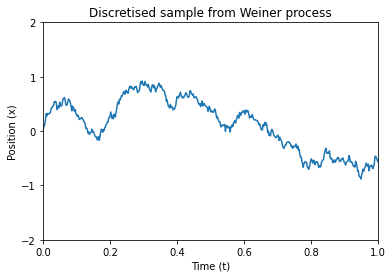

In [325]:
plt.plot(t, W)

plt.xticks(np.linspace(0, T, 6))
plt.yticks(np.linspace(-2, 2, 5))
plt.xlim([0, 1])
plt.ylim([-2, 2])

plt.title('Discretised sample from Weiner process')
plt.xlabel('Time (t)')
plt.ylabel('Position (x)')
plt.show()

## Sampling from a mapping of a Wiener process

In [326]:
np.random.seed(0)

T = 1
N = 500
S = 1000
dt = T / N

t = np.linspace(0, T, N)
dW = dt ** 0.5 * np.random.normal(size=(N, S))
W = np.cumsum(dW, axis=0)

# Shift by one timestep and set 
W[1:] = W[:-1]
W[0] = 0

U = np.exp(t[:, None] + 0.5 * W)
U_mean = np.mean(U, axis=1)
U_stdev = np.var(U, axis=1) ** 0.5

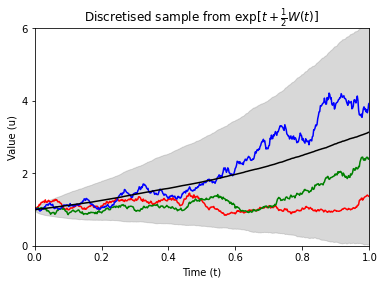

In [327]:
plt.plot(t, U[:, 0], color='r')
plt.plot(t, U[:, 1], color='g')
plt.plot(t, U[:, 2], color='b')

plt.plot(t, U_mean, color='k')
plt.fill_between(t,
                 U_mean - 2 * U_stdev,
                 U_mean + 2 * U_stdev,
                 color='gray',
                 alpha=0.3)

plt.xticks(np.linspace(0, T, 6))
plt.yticks(np.linspace(0, 6, 4))
plt.xlim([0, 1])
plt.ylim([0, 6])

plt.title(r'Discretised sample from $\exp[t + \frac{1}{2} W(t)]$')
plt.xlabel('Time (t)')
plt.ylabel('Value (u)')
plt.show()

## Evaluating a stochastic integral

In [328]:
def h(x):
    return x

In [329]:
T = 1
N = int(1e6)
dt = T / N

# Set random seed
np.random.seed(3)

# Sample wiener process interval-variables
dW = dt ** 0.5 * np.random.normal(size=(N,))

# Wiener process is the cumulative sum of the interval-variables
W = np.concatenate([[0], np.cumsum(dW)])

# Evaluate the Ito integral
H = h(W)
ito_approx = np.sum(H[:-1] * dW)
ito_exact = 0.5 * W[-2] ** 2 - 0.5 * T

# The Wiener process must be evaluated at the midpoints to evaluate the Stratonovich integral
W_midpoint = (W[:-1] + W[1:]) / 2
h_midpoint = h(W_midpoint)
h_midpoint = h_midpoint + np.random.normal(0, (dt / 4) ** 0.5, size=(N,))

# Evaluate the Stratonovich integral
strat_approx = np.sum(h_midpoint * dW)
strat_exact = 0.5 * W[-2] ** 2

print(f'Ito integral approximation (exact): {ito_approx:.3f} ({ito_exact:.3f})')
print(f'Stratonovich approximation (exact): {strat_approx:.3f} ({strat_exact:.3f})')

Ito integral approximation (exact): 1.419 (1.415)
Stratonovich approximation (exact): 1.917 (1.915)


## Euler-Maruyama method

<div class="definition">
    
**Definition (Euler-Maruyama method)** Given a scalar SDE with drift and diffusion functions $f$ and $g$
    \begin{align}dX(t) = f(X(t))dt + g(X(t)) dW(t),\end{align}
    the Euler-Maruyama method approximates $X$ by
    \begin{align} X_{j + 1} = X_j + f(X_j) \Delta t + g(X_j) \Delta W_j,\end{align}
    where $\Delta t > 0$ is the time step, $X_j = X(\tau_j), W_j = W(\tau_j)$ and $\tau_j = j\Delta t$.
    
</div>
<br>

In [460]:
def euler_maruyama(seed, X0, T, N, f, g):
    
    np.random.seed(seed)
    
    dt = T / N
    
    X = [X0]
    
    t = np.linspace(0, T, N + 1)
    
    dW = dt ** 0.5 * np.random.normal(size=(N,))
    
    for i in range(N):
        
        dX = f(X[-1], t[i]) * dt + g(X[-1], t[i]) * dW[i]
        
        X.append(X[-1] + dX)
        
    W = np.concatenate([[0], np.cumsum(dW)])
    
    return t, X, W

In [461]:
def f_g_black_scholes(lamda, mu):
    
    def f(X, t):
        return lamda * X
    
    def g(X, t, grad=False):
        return mu if grad else mu * X
    
    return f, g

In [462]:
def exact_black_scholes(X0, t, W, lamda, mu):
    return X0 * np.exp((lamda - 0.5 * mu ** 2) * t + mu * W)

In [528]:
lamda = 2
mu = 1

seed = 0
X0 = 1
T = 1
N = int(1e2)

f, g = f_g_black_scholes(lamda=lamda, mu=mu)

t, X, W = euler_maruyama(seed=seed, X0=X0, T=T, N=N, f=f, g=g)
X_exact = exact_black_scholes(X0=X0, t=t, W=W, lamda=lamda, mu=mu)

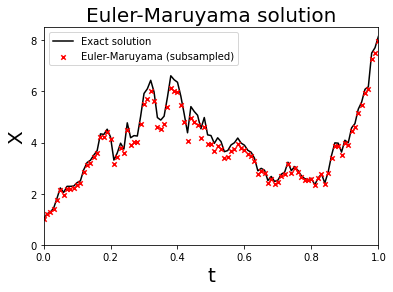

In [529]:
plt.plot(t, X_exact, color='k', zorder=1, label='Exact solution')
plt.scatter(t, X, s=20, marker='x', color='red', zorder=2, label='Euler-Maruyama (subsampled)')
plt.legend()
plt.xlim([0, T])
plt.xticks(np.linspace(0, 1, 6))
plt.yticks(np.linspace(0, 8, 5))
plt.title('Euler-Maruyama solution', fontsize=20)
plt.xlabel('t', fontsize=20)
plt.ylabel('X', fontsize=20)
plt.show()

In [530]:
def f_g_sine(omega, mu):
    
    def f(X, t):
        return 2 * np.pi * omega * np.cos(2 * np.pi * omega * t)
    
    def g(X, t):
        return mu * X
    
    return f, g

In [531]:
omega = 2
mu = 0.8

seed = 0
X0 = 1
T = 2
N = int(1e5)

f, g = f_g_sine(omega=omega, mu=mu)

t, X, W = euler_maruyama(seed=seed, X0=X0, T=T, N=N, f=f, g=g)

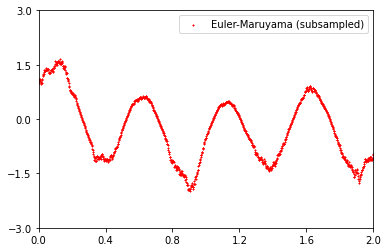

In [532]:
plt.scatter(t[::100], X[::100], s=1, marker='x', color='red', zorder=2, label='Euler-Maruyama (subsampled)')
plt.legend()
plt.xlim([0, T])
plt.xticks(np.linspace(0, T, 6))
plt.yticks(np.linspace(-3, 3, 5))
plt.show()

## Strong and weak convergence

<div class="definition">
    
**Definition (Strong convergence)** A method for approximating a stochastic process $X(t)$ is said to have strong order of convergence $\gamma$ if there exists a constant such that
    \begin{align}\mathbb{E}|X_n - X(\tau_n)| \leq C\Delta t^\gamma\end{align}
    for any fixed $\tau_n = n\Delta t \in [0, T]$ and $\Delta t$ sufficiently small.

</div>
<br>

A weaker condition for convergence is the amount by which the expected values of the stochastic process depart from each other. 

<div class="definition">
    
**Definition (Weak convergence)** A method for approximating a stochastic process $X(t)$ is said to have weak order of convergence $\gamma$ if there exists a constant such that
    \begin{align}|\mathbb{E}[X_n] - \mathbb{E}[X(\tau_n)]| \leq C\Delta t^\gamma\end{align}
    for any fixed $\tau_n = n\Delta t \in [0, T]$ and $\Delta t$ sufficiently small.

</div>
<br>

The paper states without proof that, under conditions on $f$ and $g$, Euler-Maruyama has strong order of convergence $\frac{1}{2}$ and weak order of convergence $1$. We do not provide a proof for any of the above statements, but instead evaluate the rate of convergence empirically, as in the paper.

In [533]:
def parallel_euler_maruyama(seed, num_paths, X0, T, N, f, g):
    
    np.random.seed(seed)
    
    dt = T / N
    
    X = X0 * np.ones(shape=(num_paths, N + 1))
    
    t = np.linspace(0, T, N + 1)
    
    dW = dt ** 0.5 * np.random.normal(size=(num_paths, N))
    
    for i in range(N):
        
        X[:, i+1] = X[:, i] + f(X[:, i], t[i]) * dt + g(X[:, i], t[i]) * dW[:, i]
        
    W = np.concatenate([np.zeros(shape=(num_paths, 1)), np.cumsum(dW, axis=1)], axis=1)
    
    return t, X, W

In [563]:
lamda = 2
mu = 1

seed = 0
X0 = 1
T = 1
Ns = (10 ** np.linspace(2, 4, 4)).astype(dtype=np.int)
num_paths = int(1e4)

f, g = f_g_black_scholes(lamda=lamda, mu=mu)

dts = []
X_abs_diffs = []

for N in Ns:
    
    t, X, W = parallel_euler_maruyama(seed=seed, num_paths=num_paths, X0=X0, T=T, N=N, f=f, g=g)
    X_exact = exact_black_scholes(X0=X0, t=t[None, :], W=W, lamda=lamda, mu=mu)
    
    dts.append(T / N)
    
    X_abs_diff = np.abs(X[:, -1] - X_exact[:, -1])
    X_abs_diffs.append(X_abs_diff)
    
X_abs_diffs = np.stack(X_abs_diffs, axis=0)
em_strong_errors = np.mean(X_abs_diffs, axis=1)

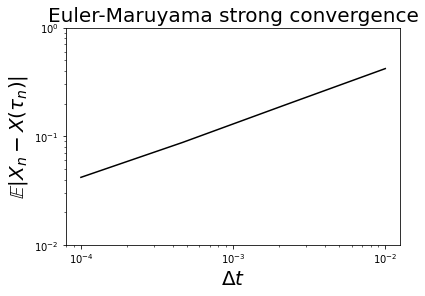

In [589]:
plt.plot(dts, em_strong_errors, color='k')
plt.loglog()
plt.yticks([1e-2, 1e-1, 1e0])
plt.xlabel(r'$\Delta t$', fontsize=20)
plt.ylabel(r'$\mathbb{E}|X_n - X(\tau_n)|$', fontsize=20)
plt.title('Euler-Maruyama strong convergence', fontsize=20)
plt.show()

In [586]:
lamda = 2
mu = 1

seed = 0
X0 = 1
T = 1
Ns = (10 ** np.linspace(2, 4, 4)).astype(dtype=np.int)
num_paths = int(1e4)

f, g = f_g_black_scholes(lamda=lamda, mu=mu)

dts = []
X_approx = []
X_exacts = []

for N in Ns:
    
    t, X, W = parallel_euler_maruyama(seed=seed, num_paths=num_paths, X0=X0, T=T, N=N, f=f, g=g)
    X_exact = exact_black_scholes(X0=X0, t=t[None, :], W=W, lamda=lamda, mu=mu)
    
    dts.append(T / N)
    X_approx.append(X[:, -1])
    X_exacts.append(X_exact[:, -1])
    
X_approx = np.stack(X_approx, axis=0)
X_exacts = np.stack(X_exacts, axis=0)

X_approx_means = np.mean(X_approx, axis=-1)
X_exacts_means = np.mean(X_exacts, axis=-1)

em_weak_errors = np.abs(X_approx_means - X_exacts_means)

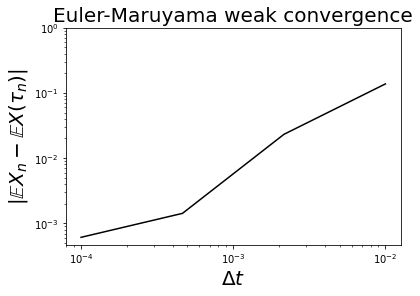

In [587]:
plt.plot(dts, em_weak_errors, color='k')
plt.loglog()
plt.yticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlabel(r'$\Delta t$', fontsize=20)
plt.ylabel(r'$|\mathbb{E}X_n - \mathbb{E}X(\tau_n)|$', fontsize=20)
plt.title('Euler-Maruyama weak convergence', fontsize=20)
plt.show()

# Milstein's higher order method

<div class="definition">
    
**Definition (Milstein's method)** Given a scalar SDE with drift and diffusion functions $f$ and $g$
    \begin{align}dX(t) = f(X(t))dt + g(X(t)) dW(t),\end{align}
    the Milstein method approximates $X$ by
    \begin{align} X_{j + 1} = X_j + f(X_j) \Delta t + g(X_j) \Delta W_j + \frac{1}{2}g(X_j)g'(X_j) (\Delta W_j^2 - \Delta t),\end{align}
    where $\Delta t > 0$ is the time step, $X_j = X(\tau_j), W_j = W(\tau_j)$ and $\tau_j = j\Delta t$.
    
</div>
<br>

In [536]:
def parallel_milstein(seed, num_paths, X0, T, N, f, g):
    
    np.random.seed(seed)
    
    dt = T / N
    
    X = X0 * np.ones(shape=(num_paths, N + 1))
    
    t = np.linspace(0, T, N + 1)
    
    dW = dt ** 0.5 * np.random.normal(size=(num_paths, N))
    
    for i in range(N):
        
        # Compute the EM term and the higher order correction term
        dX = f(X[:, i], t[i]) * dt + g(X[:, i], t[i]) * dW[:, i]
        dX = dX + 0.5 * g(X[:, i], t[i]) * g(X[:, i], t[i], grad=True) * (dW[:, i] ** 2 - dt)
        
        X[:, i+1] = X[:, i] + dX
        
    W = np.concatenate([np.zeros(shape=(num_paths, 1)), np.cumsum(dW, axis=1)], axis=1)
    
    return t, X, W

In [537]:
lamda = 2
mu = 1

seed = 0
X0 = 1
T = 1
N = int(1e2)
num_paths = 1

f, g = f_g_black_scholes(lamda=lamda, mu=mu)

t, X, W = parallel_milstein(seed=seed, num_paths=num_paths, X0=X0, T=T, N=N, f=f, g=g)
X_exact = exact_black_scholes(X0=X0, t=t[None, :], W=W, lamda=lamda, mu=mu)

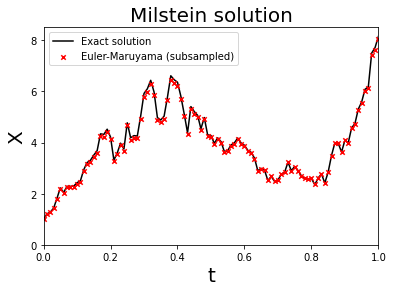

In [538]:
plt.plot(t, X_exact[0, :], color='k', zorder=1, label='Exact solution')
plt.scatter(t, X[0, :], s=20, marker='x', color='red', zorder=2, label='Euler-Maruyama (subsampled)')
plt.legend()
plt.xlim([0, T])
plt.xticks(np.linspace(0, 1, 6))
plt.yticks(np.linspace(0, 8, 5))
plt.title('Milstein solution', fontsize=20)
plt.xlabel('t', fontsize=20)
plt.ylabel('X', fontsize=20)
plt.show()

In [572]:
lamda = 2
mu = 1

seed = 0
X0 = 1
T = 1
Ns = (10 ** np.linspace(2, 4, 4)).astype(dtype=np.int)
num_paths = int(1e4)

f, g = f_g_black_scholes(lamda=lamda, mu=mu)

dts = []
X_abs_diffs = []

for N in Ns:
    
    t, X, W = parallel_milstein(seed=seed, num_paths=num_paths, X0=X0, T=T, N=N, f=f, g=g)
    X_exact = exact_black_scholes(X0=X0, t=t[None, :], W=W, lamda=lamda, mu=mu)
    
    dts.append(T / N)
    
    X_abs_diff = np.abs(X[:, -1] - X_exact[:, -1])
    X_abs_diffs.append(X_abs_diff)
    
X_abs_diffs = np.stack(X_abs_diffs, axis=0)
mil_strong_errors = np.mean(X_abs_diffs, axis=1)

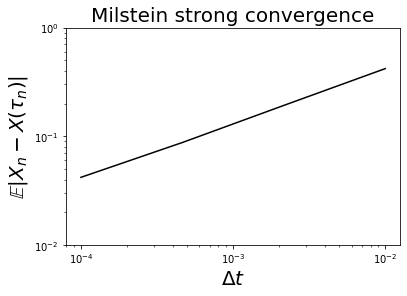

In [580]:
plt.plot(dts, em_strong_errors, color='k')
plt.loglog()
plt.yticks([1e-2, 1e-1, 1e0])
plt.xlabel(r'$\Delta t$', fontsize=20)
plt.ylabel(r'$\mathbb{E}|X_n - X(\tau_n)|$', fontsize=20)
plt.title('Milstein strong convergence', fontsize=20)
plt.show()

In [581]:
lamda = 2
mu = 1

seed = 0
X0 = 1
T = 1
Ns = (10 ** np.linspace(2, 4, 4)).astype(dtype=np.int)
num_paths = int(1e4)

f, g = f_g_black_scholes(lamda=lamda, mu=mu)

dts = []
X_approx = []
X_exacts = []

for N in Ns:
    
    t, X, W = parallel_milstein(seed=seed, num_paths=num_paths, X0=X0, T=T, N=N, f=f, g=g)
    X_exact = exact_black_scholes(X0=X0, t=t[None, :], W=W, lamda=lamda, mu=mu)
    
    dts.append(T / N)
    X_approx.append(X[:, -1])
    X_exacts.append(X_exact[:, -1])
    
X_approx = np.stack(X_approx, axis=0)
X_exacts = np.stack(X_exacts, axis=0)

X_approx_means = np.mean(X_approx, axis=-1)
X_exacts_means = np.mean(X_exacts, axis=-1)

mil_weak_errors = np.abs(X_approx_means - X_exacts_means)

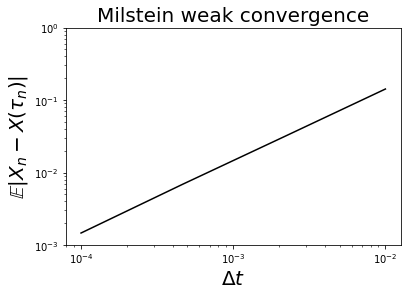

In [579]:
plt.plot(dts, mil_weak_errors, color='k')
plt.loglog()
plt.yticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlabel(r'$\Delta t$', fontsize=20)
plt.ylabel(r'$|\mathbb{E}X_n - \mathbb{E}X(\tau_n)|$', fontsize=20)
plt.title('Milstein weak convergence', fontsize=20)
plt.show()